# 🪐 Martian Terrain Segmentation — Technical Blog-Style Documentation

Quick Content Summary:

- Loading the AI4Mars NASA dataset (Hugging Face: `hassanjbara/AI4MARS`).
  - Classes: soil, bedrock, sand, big rock (null pixels ignored).
- Training a heavier weight Attention U-Net on Martian terrain labels
- Distilling process to get a lightweight model with comparable performance
- Evaluating pixel accuracy and mean IoU.
- Visualizing predictions vs. ground truth.
- Explainability:
  - Grad-CAM heatmaps.
  - Integrated Gradients saliency.
  - "Neural PCA" of intermediate feature activations.
- Uncertainty:
  - showing th uncertainty of pictures as heatmap to check calibration

### A few things to say
In the context of an ESA application I made this fun little semactic segmentation project. The goal is to get a good performing lightweight model to do semantic segmentation on a martian terrain dataset. Because the context here is to make a model that is aiding human interpretation of the data I added some of my facorite methods from the realm of trustworthy machine learning. This offers explainability and interpretability of the model to be able to detect shortcuts or biases of the model in the attempt of opening the black box. I think these are essential in every case where we want to really trust the model and understand how and what it is actually learning. Keep in mind, none of these methods, especially when only using each of them alone, this does never assure right behaviour of the model but taken together they enable a good understanding and robustness.

The Notebook will display only the higher level concepts of the things that are implemented here. For the detailed code descriptions look in the docs that can also be found here on the website.

What will follow is a very typical pytorch CNN pipeline, no magic there. I will at short explanations for the more non-standard interesting parts. The references can be found at the end along with an outlook on whats still missing in my opinion (I will publish the incomplete version as I had only a few to do this for the application).

**This is just imports and training settings:**

In [2]:
import os
import random
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from martian_terrain_segmentation.models import create_unet
from martian_terrain_segmentation.dataloader import (
    create_ai4mars_dataloaders,
    AI4MARS_CLASS_NAMES,
    AI4MARS_IGNORE_INDEX,
)
from martian_terrain_segmentation.optimizers import create_optimizer, create_cosine_scheduler_with_warmup
from martian_terrain_segmentation.train_utils import train_one_epoch, evaluate, save_checkpoint, load_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_size = 256
batch_size = 10
num_workers = 4
num_classes = len(AI4MARS_CLASS_NAMES)
num_epochs = 40

use_muon = False       
use_amp = True 

out_dir = Path("./outputs")
out_dir.mkdir(exist_ok=True, parents=True)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Using device: cuda


**Here we load the data. You will have the options to load only small parts of the data with 'max_train_sample, max_test_samples. Also there where a  few images with differeing type that led to errors. When you are loading the data the first time from put scan_sporious=True to threw out these few images.**

In [ ]:
# Data: AI4Mars dataloaders (train/val/test)
loaders = create_ai4mars_dataloaders(
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    val_fraction=0.1,
    to_rgb=False,
    seed=seed,
    cache_dir="./data/hf_cache",  
    #max_train_samples=100,         
    #max_test_samples=50,
    use_local_disk_copy=True,
    local_disk_path="./data/ai4mars_hf_on_disk",
    scan_spurious=False,
    valid_indices_cache_dir="./data/ai4mars_valid_indices",
)

train_loader = loaders.train
val_loader = loaders.val
test_loader = loaders.test

print(
    f"Train batches: {len(train_loader)}, "
    f"Val batches: {len(val_loader)}, "
    f"Test batches: {len(test_loader)}"
)


[AI4MarsHFDataset] Loaded 13018 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_train.npy
[AI4MarsHFDataset] Loaded 1449 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_val.npy
[AI4MarsHFDataset] Loaded 1597 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_test.npy
Train batches: 1302, Val batches: 145, Test batches: 160


# 1. The Attention U-Net (Teacher Model)

The **Attention U-Net** extends the classical U-Net by modulating skip connections using **attention gates (AG)**.  
This helps suppress irrelevant features and highlight important spatial structures.

## 🔍 1.1 Attention Gate (Mathematical Overview)

Given encoder feature map $x \in \mathbb{R}^{F_l \times H \times W}$  
and decoder gating signal $g \in \mathbb{R}^{F_g \times H' \times W'}$:

1. Linear transforms:

$$
x' = W_x x,\qquad g' = W_g g
$$

2. Align feature map sizes (interpolation)

3. Combine:

$$
q = \mathrm{ReLU}(x' + g')
$$

4. Produce attention mask:

$$
\alpha = \sigma(W_\psi q)
$$

5. Apply gating:

$$
\tilde{x} = \alpha \odot x
$$

This mask blocks irrelevant encoder features and emphasizes important ones (e.g., rock boundaries).

### Why Attention Helps

- Selects semantically relevant spatial details  
- Avoids passing noise (e.g., rover artifacts)  
- Improves fine structure segmentation  
- Stronger gradients passed through skip connections  

**Reference:**  
**Attention U-Net: Learning Where to Look for the Pancreas**  
https://arxiv.org/abs/1804.03999


In [ ]:
from martian_terrain_segmentation.models import create_teacher_unet
teacher_learning_rate = 1e-4
teacher_weight_decay = 1e-2
 
# Initializing the teacher model
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)

teacher_optimizer = create_optimizer(
    teacher,
    lr=teacher_learning_rate,
    weight_decay=teacher_weight_decay,
    use_muon=use_muon,
)

teacher_scheduler = create_cosine_scheduler_with_warmup(
    teacher_optimizer,
    num_warmup_steps=int(0.1 * num_epochs * len(train_loader)),
    num_training_steps=num_epochs * len(train_loader),
)


ModuleNotFoundError: No module named 'martian_terrain_segmentation'

In [ ]:
"""history_teacher = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}
# Training loop for the teacher model
best_teacher_miou = -1.0

for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch(
        model=teacher,
        dataloader=train_loader,
        optimizer=teacher_optimizer,
        device=device,
        num_classes=num_classes,
        use_amp=use_amp,
        use_tqdm=True,
        epoch=epoch,
        num_epochs=num_epochs,
        scheduler=teacher_scheduler,
    )

    val_metrics = evaluate(
        model=teacher,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
        use_tqdm=True,
    )

    if val_metrics["miou"] > best_teacher_miou:
        best_teacher_miou = val_metrics["miou"]
        save_checkpoint(
            path="checkpoints/best_teacher.pt",
            model=teacher,
            optimizer=teacher_optimizer,
            scheduler=teacher_scheduler,
            epoch=epoch,
            metrics={"val_miou": best_teacher_miou},
        )
    history_teacher["train_loss"].append(train_metrics["loss"])
    history_teacher["train_miou"].append(train_metrics["miou"])
    history_teacher["val_loss"].append(val_metrics["loss"])
    history_teacher["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )"""

'history_teacher = {\n    "train_loss": [],\n    "train_miou": [],\n    "val_loss": [],\n    "val_miou": [],\n}\n# Training loop for the teacher model\nbest_teacher_miou = -1.0\n\nfor epoch in range(1, num_epochs + 1):\n    train_metrics = train_one_epoch(\n        model=teacher,\n        dataloader=train_loader,\n        optimizer=teacher_optimizer,\n        device=device,\n        num_classes=num_classes,\n        use_amp=use_amp,\n        use_tqdm=True,\n        epoch=epoch,\n        num_epochs=num_epochs,\n        scheduler=teacher_scheduler,\n    )\n\n    val_metrics = evaluate(\n        model=teacher,\n        dataloader=val_loader,\n        device=device,\n        num_classes=num_classes,\n        use_tqdm=True,\n    )\n\n    if val_metrics["miou"] > best_teacher_miou:\n        best_teacher_miou = val_metrics["miou"]\n        save_checkpoint(\n            path="checkpoints/best_teacher.pt",\n            model=teacher,\n            optimizer=teacher_optimizer,\n            schedu

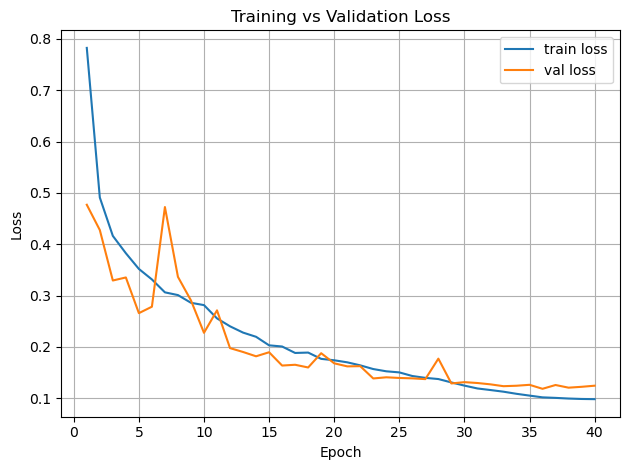

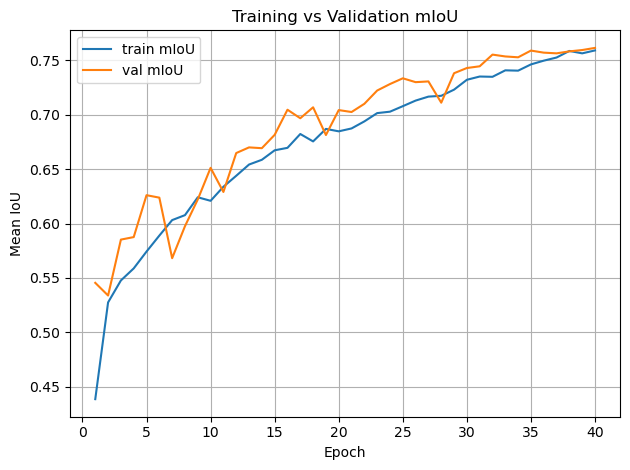

In [ ]:
# Plot training curves
import pandas as pd
history_teacher =  pd.read_csv("outputs/teacher_training_history.csv")
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history_teacher["train_loss"], label="train loss")
plt.plot(epochs, history_teacher["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history_teacher["train_miou"], label="train mIoU")
plt.plot(epochs, history_teacher["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)

load_checkpoint(
    path="checkpoints/best_teacher.pt",
    model=teacher,
    optimizer=None,
    scheduler=None,
    map_location=device,
)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=m

[checkpoint] Loaded model weights from checkpoints/best_teacher.pt


# 2. Knowledge Distillation (Teacher → Student)

We train:

- A **large Attention U-Net** → high accuracy  
- A **small U-Net** → efficient, lightweight  

But instead of training the small model directly on labels, we **distill** the knowledge from the teacher.

##  2.1 Why Distillation Works Better Than Raw Labels

The teacher provides *rich, structured information* that one-hot labels do not.

### Soft Targets Contain Class Similarities

Define soft teacher probabilities:

$$
p_t^{(T)} = \mathrm{softmax}\left(\frac{z_t}{T}\right)
$$

This reveals:
- Soil pixels that are slightly "sand-like"
- Bedrock with high uncertainty boundaries
- Ambiguous transitions between materials

### Benefits:

- Avoids overconfidence  
- Improves generalization  
- Provides smoother decision boundaries  
- Encodes class relationships  
- Student mimics teacher's *entire function*, not just datasets  

##  2.2 Distillation Loss for Segmentation

We combine supervised CE + KL divergence:

$$
\mathcal{L}_{CE} = \mathrm{CE}(y, p_s)
$$

$$
\mathcal{L}_{KD} = T^2 \cdot \mathrm{KL}\left(p^{(T)}_t \;\|\; p^{(T)}_s\right)
$$

Final:

$$
\mathcal{L} = (1 - \lambda)\mathcal{L}_{CE} + \lambda\mathcal{L}_{KD}
$$

**Reference:**  
**Distilling the Knowledge in a Neural Network**  
https://arxiv.org/abs/1503.02531


In [ ]:
from martian_terrain_segmentation.distillation import SegmentationKDLoss
epoch_student = 30
teacher_learning_rate = 1e-4
teacher_weight_decay = 1e-2
student_learning_rate = 5e-4
student_weight_decay = 5e-2
# Initializing student model and knowledge distillation setup
# load pretrained teacher (frozen)
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)
load_checkpoint("checkpoints/best_teacher.pt", model=teacher, optimizer=None, scheduler=None, map_location=device)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# fresh student
student = create_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=16,
    bilinear=True,
).to(device)

optimizer = create_optimizer(
    student,
    lr=student_learning_rate,         
    weight_decay=student_weight_decay,
    use_muon=use_muon,
)

scheduler = create_cosine_scheduler_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_epochs * len(train_loader)),
    num_training_steps=num_epochs * len(train_loader),
)

kd_loss_fn = SegmentationKDLoss(
    ignore_index=AI4MARS_IGNORE_INDEX,
    alpha=0.5,
    T=2.0,
)


[checkpoint] Loaded model weights from checkpoints/best_teacher.pt
[optimizers] Using NAdam (NadamW-style) optimizer.


In [ ]:
"""from tqdm import tqdm
best_student_miou = -1.0
history = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}

for epoch_student in range(1, num_epochs + 1):
    print(f"\n[Distillation] Epoch {epoch}/{num_epochs}")
    student.train()

    if use_amp:
        scaler = torch.cuda.amp.GradScaler(enabled=True)
    else:
        scaler = None

    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"KD Train {epoch}/{num_epochs}", unit="batch", leave=False)

    for imgs, masks in pbar:
        imgs = imgs.to(device, non_blocking=True).float()
        masks = masks.to(device, non_blocking=True).long()
        batch_size = imgs.size(0)
        total_samples += batch_size

        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            teacher_logits = teacher(imgs)

        if use_amp:
            with torch.cuda.amp.autocast():
                student_logits = student(imgs)
                loss = kd_loss_fn(student_logits, teacher_logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            student_logits = student(imgs)
            loss = kd_loss_fn(student_logits, teacher_logits, masks)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * batch_size
        avg_loss = running_loss / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.3f}")

    # eval student
    val_metrics = evaluate(
        model=student,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
        use_tqdm=True,
    )

    if val_metrics["miou"] > best_student_miou:
        best_student_miou = val_metrics["miou"]
        save_checkpoint(
            path="checkpoints/best_student_kd.pt",
            model=student,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            metrics={"val_miou": best_student_miou},
        )

    history["train_loss"].append(train_metrics["loss"])
    history["train_miou"].append(train_metrics["miou"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  KD Val - loss: N/A, mIoU: {val_metrics['miou']:.4f}, pix acc: {val_metrics['pixel_acc']:.4f}"
    )
"""

'from tqdm import tqdm\nbest_student_miou = -1.0\nhistory = {\n    "train_loss": [],\n    "train_miou": [],\n    "val_loss": [],\n    "val_miou": [],\n}\n\nfor epoch_student in range(1, num_epochs + 1):\n    print(f"\n[Distillation] Epoch {epoch}/{num_epochs}")\n    student.train()\n\n    if use_amp:\n        scaler = torch.cuda.amp.GradScaler(enabled=True)\n    else:\n        scaler = None\n\n    running_loss = 0.0\n    total_samples = 0\n\n    pbar = tqdm(train_loader, desc=f"KD Train {epoch}/{num_epochs}", unit="batch", leave=False)\n\n    for imgs, masks in pbar:\n        imgs = imgs.to(device, non_blocking=True).float()\n        masks = masks.to(device, non_blocking=True).long()\n        batch_size = imgs.size(0)\n        total_samples += batch_size\n\n        optimizer.zero_grad(set_to_none=True)\n\n        with torch.no_grad():\n            teacher_logits = teacher(imgs)\n\n        if use_amp:\n            with torch.cuda.amp.autocast():\n                student_logits = student

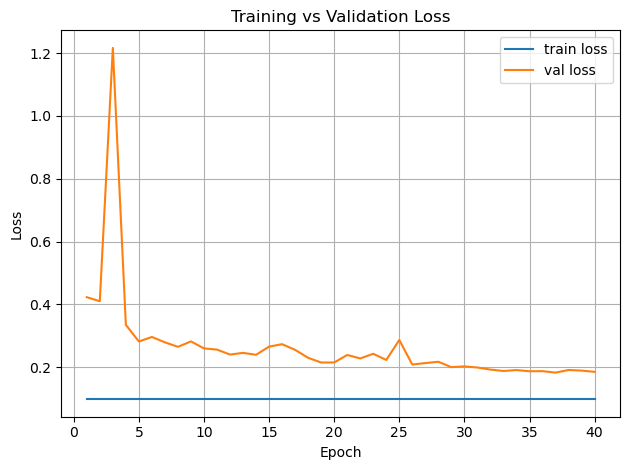

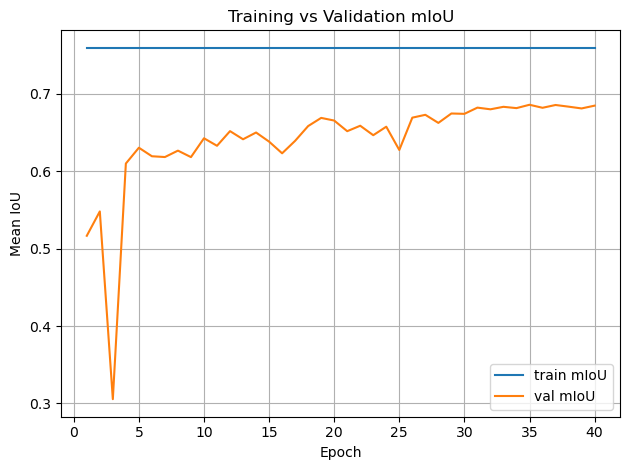

In [ ]:
# Plot training curves
import pandas as pd
history = pd.read_csv("outputs/student_kd_training_history.csv")

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history["train_miou"], label="train mIoU")
plt.plot(epochs, history["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


info = load_checkpoint(
    path="checkpoints/best_student_kd.pt",
    model=student,
    optimizer=optimizer,
    scheduler=scheduler,
    map_location=device,
)

print("Restored from epoch:", info["epoch"])
print("Stored metrics:", info["metrics"])


[checkpoint] Loaded model weights from checkpoints/best_student_kd.pt
[checkpoint] Restored optimizer state.
[checkpoint] Restored scheduler state.
Restored from epoch: 35
Stored metrics: {'val_miou': 0.685755849025393}


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=m

In [ ]:
# Evaluate on test set
test_metrics = evaluate(
    model=student,
    dataloader=test_loader,
    device=device,
    num_classes=num_classes,
)

print("\nTest metrics:")
print(
    f"  loss: {test_metrics['loss']:.4f}, "
    f"mIoU: {test_metrics['miou']:.4f}, "
    f"pix acc: {test_metrics['pixel_acc']:.4f}"
)



Test metrics:
  loss: 0.2051, mIoU: 0.6811, pix acc: 0.9398


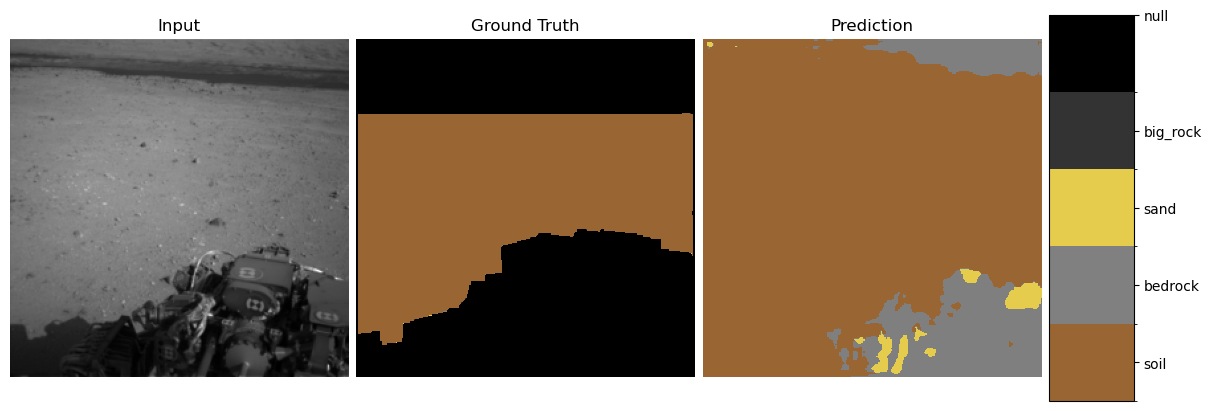

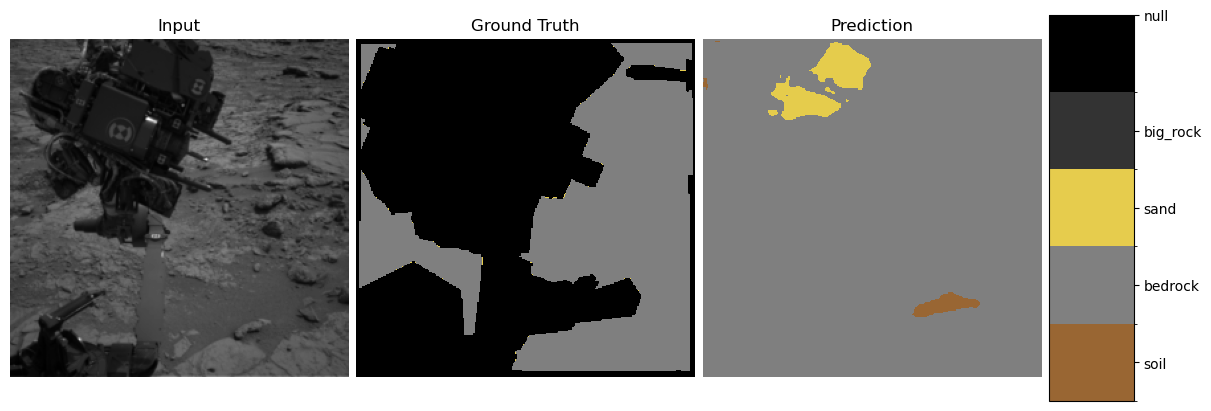

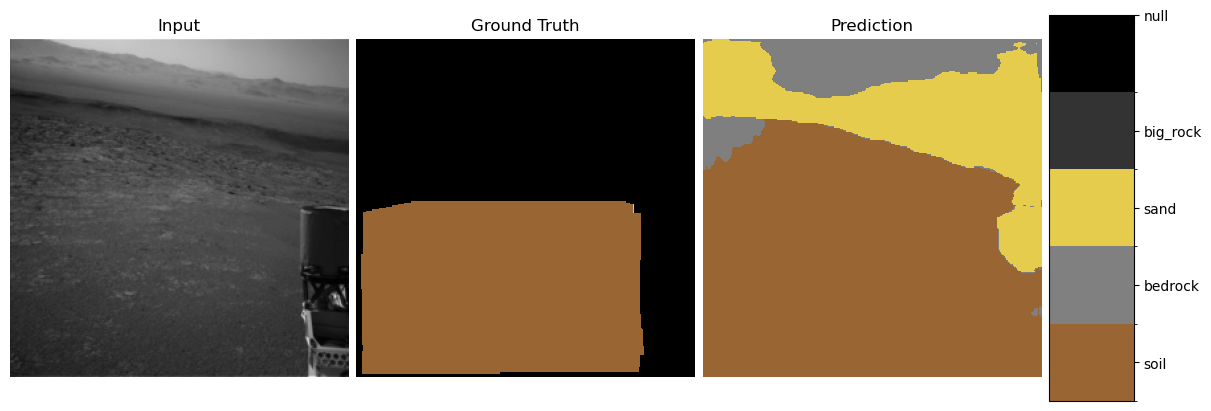

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

AI4MARS_CLASS_VALUES = [0, 1, 2, 3, 255]
AI4MARS_CLASS_NAMES = ["soil", "bedrock", "sand", "big_rock", "null"]

AI4MARS_COLORS = [
    (0.6, 0.4, 0.2),   # soil
    (0.5, 0.5, 0.5),   # bedrock
    (0.9, 0.8, 0.3),   # sand
    (0.2, 0.2, 0.2),   # big_rock
    (0.0, 0.0, 0.0),   # null (black)
]

cmap = ListedColormap(AI4MARS_COLORS)

# boundaries define the bin edges for class mapping
boundaries = [ -0.5, 0.5, 1.5, 2.5, 3.5, 255 + 0.5 ]
norm = BoundaryNorm(boundaries, cmap.N)


def decode_mask(t):
    return t.cpu().numpy()


def show_predictions(model, dataloader, num_examples=3):
    model.eval()
    imgs, masks = next(iter(dataloader))

    imgs = imgs.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(1)

    for i in range(min(num_examples, imgs.size(0))):
        img = imgs[i, 0].cpu().numpy()
        gt = masks[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        fig = plt.figure(figsize=(12, 4), constrained_layout=True)
        gs = fig.add_gridspec(1, 4, width_ratios=[1.2, 1.2, 1.2, 0.3])

        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[0, 2])
        cax = fig.add_subplot(gs[0, 3])

        ax0.imshow(img, cmap="gray")
        ax0.set_title("Input")
        ax0.axis("off")

        im1 = ax1.imshow(gt, cmap=cmap, norm=norm)
        ax1.set_title("Ground Truth")
        ax1.axis("off")

        im2 = ax2.imshow(pred, cmap=cmap, norm=norm)
        ax2.set_title("Prediction")
        ax2.axis("off")

        cb = fig.colorbar(im2, cax=cax, ticks=AI4MARS_CLASS_VALUES)
        cb.ax.set_yticklabels(AI4MARS_CLASS_NAMES)

        plt.show()


show_predictions(student, test_loader, num_examples=3)

# 3. Explainability Methods

We use three orthogonal explanation tools.

## 3.1 Grad-CAM for Segmentation

Grad-CAM highlights spatial regions responsible for class activation.

For class $c$, compute gradients:

$$
\alpha_k = \frac{1}{HW} \sum_{i,j}
\frac{\partial y_c}{\partial A_{k,ij}}
$$

Then:

$$
L^{c}_{CAM} = \mathrm{ReLU}\left(\sum_k \alpha_k A_k\right)
$$

This produces a heatmap overlay revealing where the model “looked”.

**Reference:**  
https://arxiv.org/abs/1610.02391

---

## 3.2 Integrated Gradients (IG)

IG attributes importance via a path integral from a baseline to the input:

$$
\text{IG}_i(x) = (x_i - x'_i)
\int_0^1 \frac{\partial F(x' + \alpha(x-x'))}{\partial x_i}\, d\alpha
$$

Strengths:
- Avoids gradient saturation  
- Provides fine-grained pixel-level attribution  

**Reference:**  
https://arxiv.org/abs/1703.01365


Scanning dataset once to find examples per class...

=== Class 'soil' (id=0) | 3 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


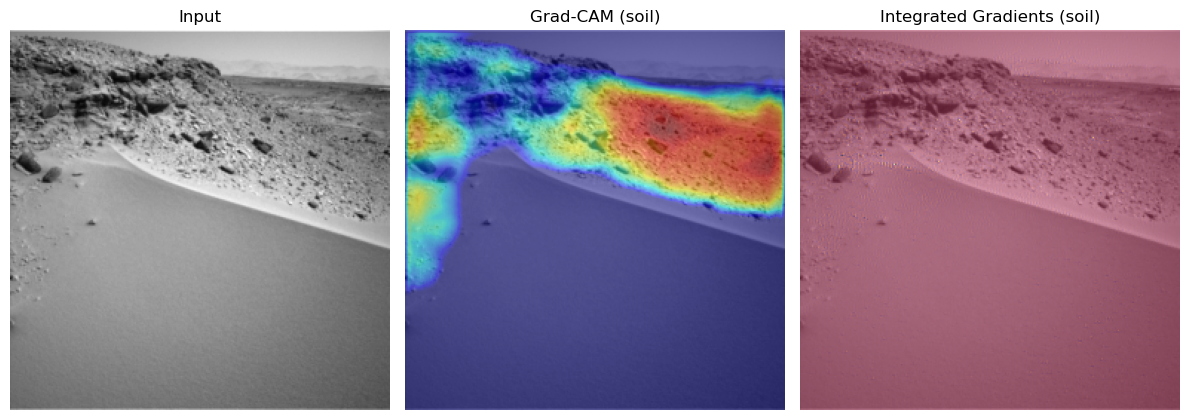


=== Class 'bedrock' (id=1) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 1)


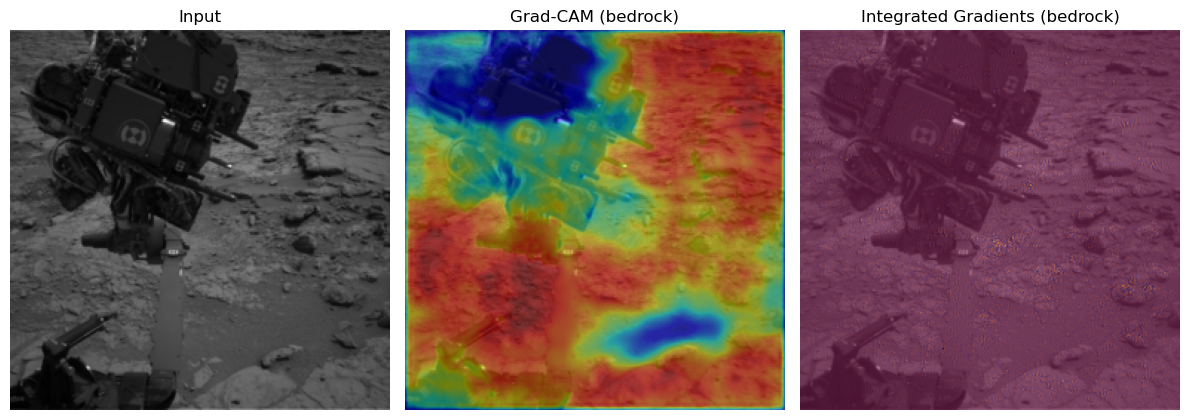


=== Class 'sand' (id=2) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


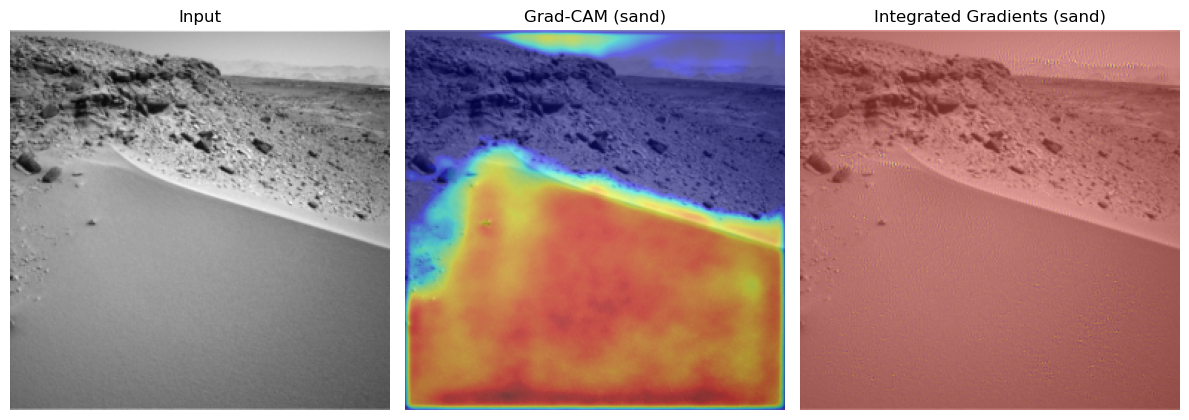


=== Class 'big_rock' (id=3) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


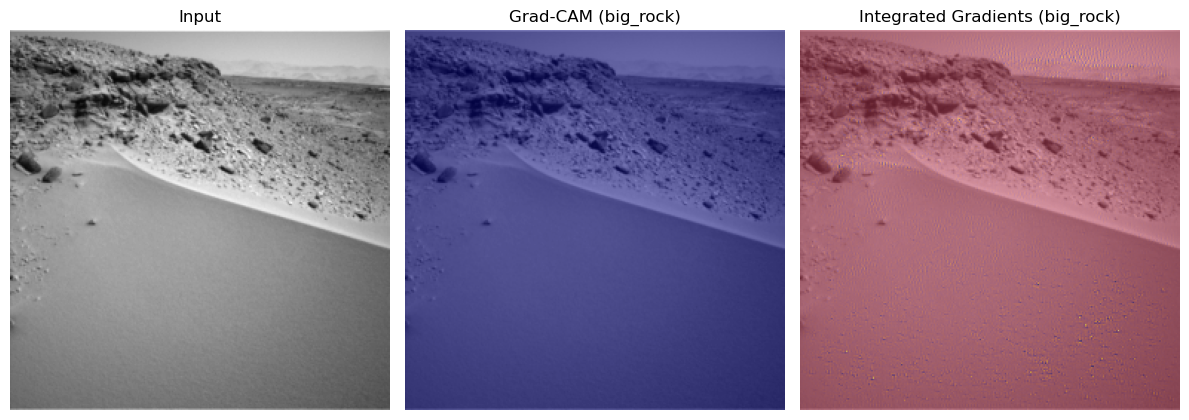

In [ ]:
# Explainability demo:
# Grad-CAM, Integrated Gradients, Neural PCA for a single test image.
from martian_terrain_segmentation.explainability import explain_per_class_examples

num_examples_per_class = 1   
ig_steps = 32

explain_per_class_examples(
    model=student,
    dataset=test_loader.dataset,
    device=device,
    num_examples_per_class=num_examples_per_class,
    ig_steps=ig_steps,
)


### Cam & Integrated Gradient Conclusion: 

You see very nice behaviour for the classes soil and bedrock. Here the correct regions seem to be activated and there are now obvious biases. Especially the fact that the model tends to ignore the mars rover in the bedrock one is a good sign for the models understanding of this class.
For the sand we might see small potential problems. There seems to be a tendency for the model to may confuse the sky for being sand.

The integrated gradients are not very informative in this setting. This could be due to the not very slient nature of these pictures and their classes. If anything you could see small input gradient activations in the sky again for the sand class.

## 3.3 Neural PCA (N-PCA)

N-PCA reveals **the principal axes of variation** in the feature space of each terrain class.

We compute:

- Penultimate features:  
$$
\phi(x)
$$

- Class weight vector:  
$$
w_c
$$

- Class embedding:  
$$
\psi_c(x) = w_c \odot \phi(x)
$$

Then perform PCA on all $\psi_c(x)$ for samples containing class $c$.

Outputs:

- Principal directions  
- Eigenvalues  
- Top-activating real images (“eigenpictures”)  

This shows what the model thinks *defines* each terrain class.


[neural PCA] Scanning dataset for class presence...
[neural PCA] Class 0: using 200 samples for PCA out of 6402 candidates.
[neural PCA] Class 1: using 200 samples for PCA out of 8351 candidates.
[neural PCA] Class 2: using 200 samples for PCA out of 4330 candidates.
[neural PCA] Class 3: using 200 samples for PCA out of 1756 candidates.

Class 'soil' (id=0), NPCA component 1, showing top 5 / 200 images.


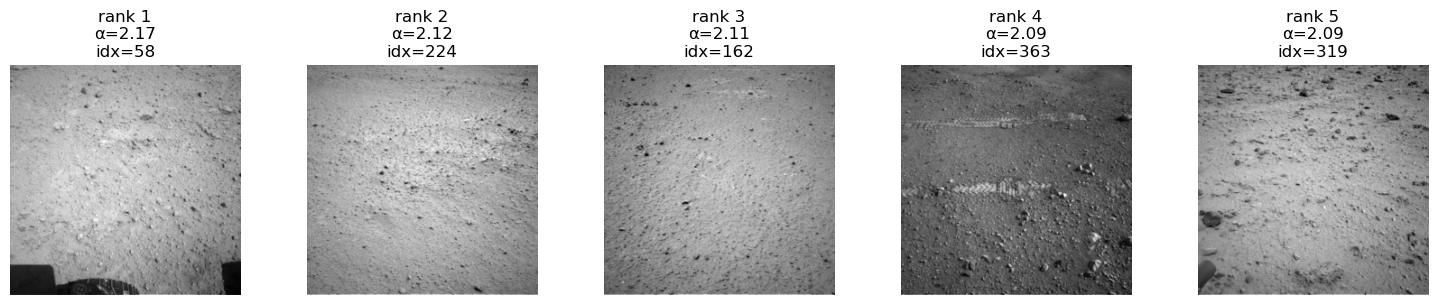


Class 'soil' (id=0), NPCA component 2, showing top 5 / 200 images.


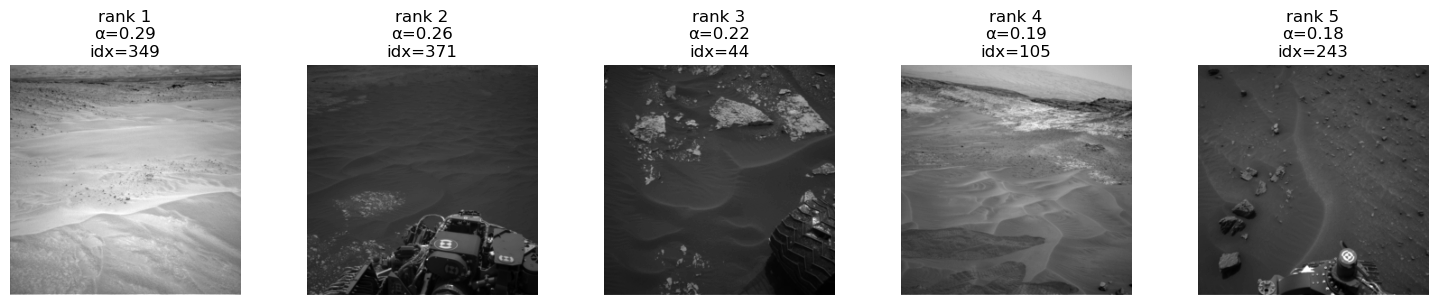


Class 'soil' (id=0), NPCA component 3, showing top 5 / 200 images.


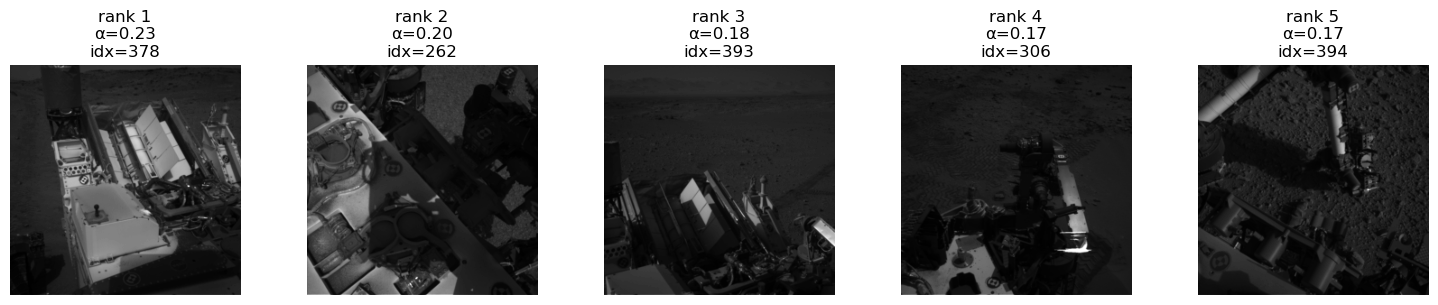


Class 'bedrock' (id=1), NPCA component 1, showing top 5 / 200 images.


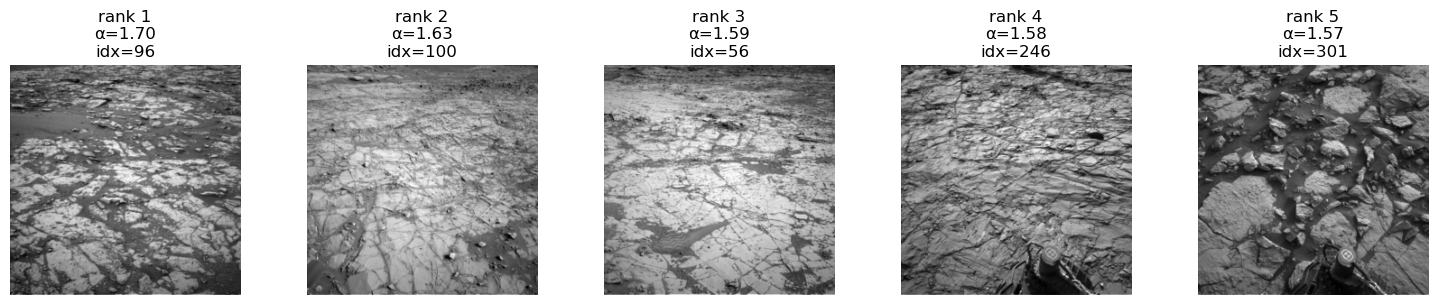


Class 'bedrock' (id=1), NPCA component 2, showing top 5 / 200 images.


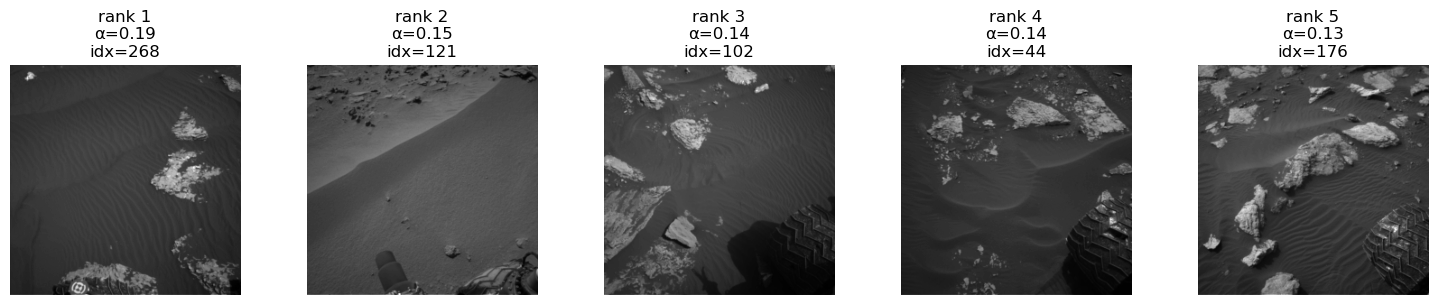


Class 'bedrock' (id=1), NPCA component 3, showing top 5 / 200 images.


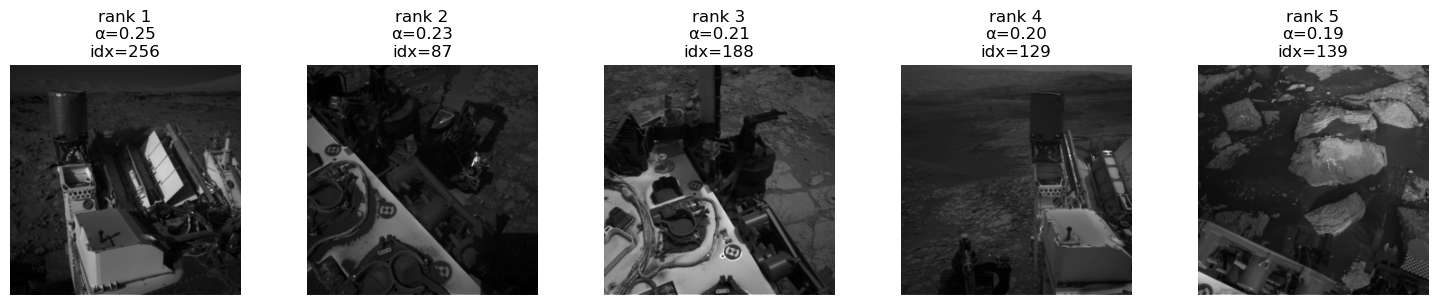


Class 'sand' (id=2), NPCA component 1, showing top 5 / 200 images.


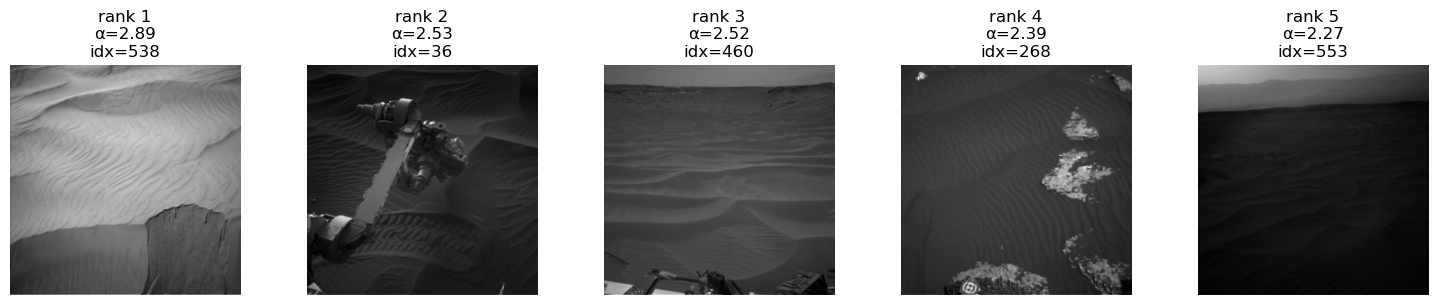


Class 'sand' (id=2), NPCA component 2, showing top 5 / 200 images.


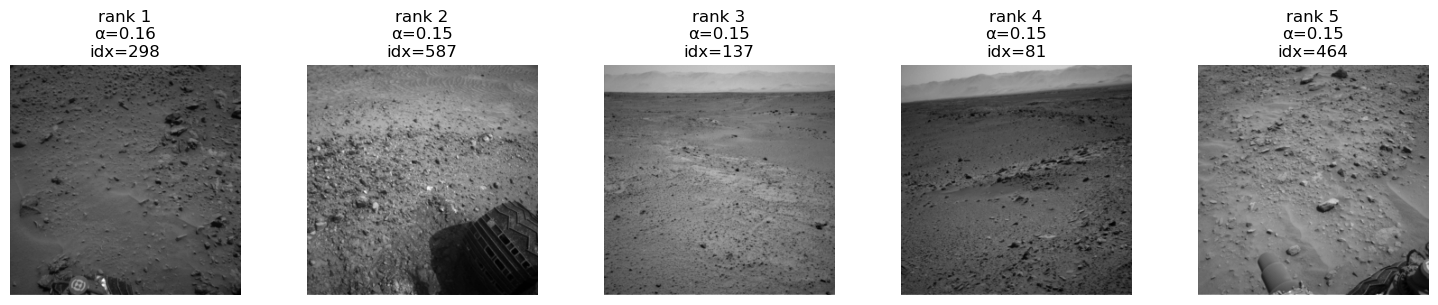


Class 'sand' (id=2), NPCA component 3, showing top 5 / 200 images.


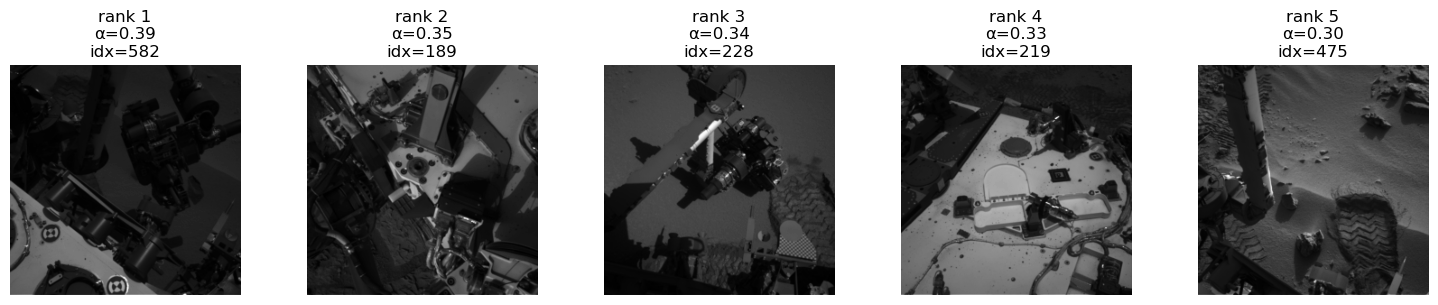


Class 'big_rock' (id=3), NPCA component 1, showing top 5 / 200 images.


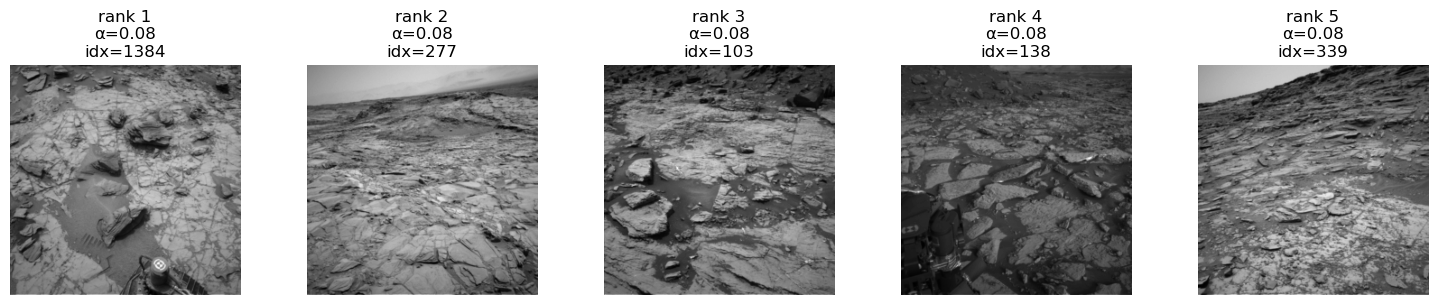


Class 'big_rock' (id=3), NPCA component 2, showing top 5 / 200 images.


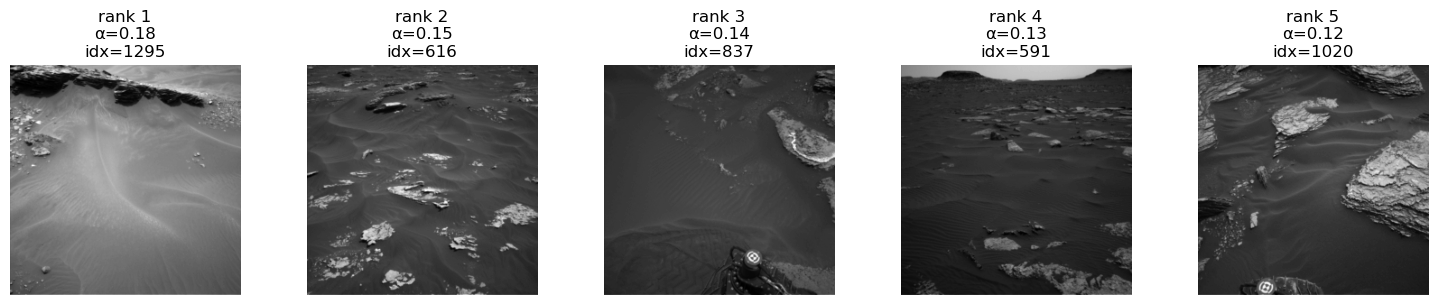


Class 'big_rock' (id=3), NPCA component 3, showing top 5 / 200 images.


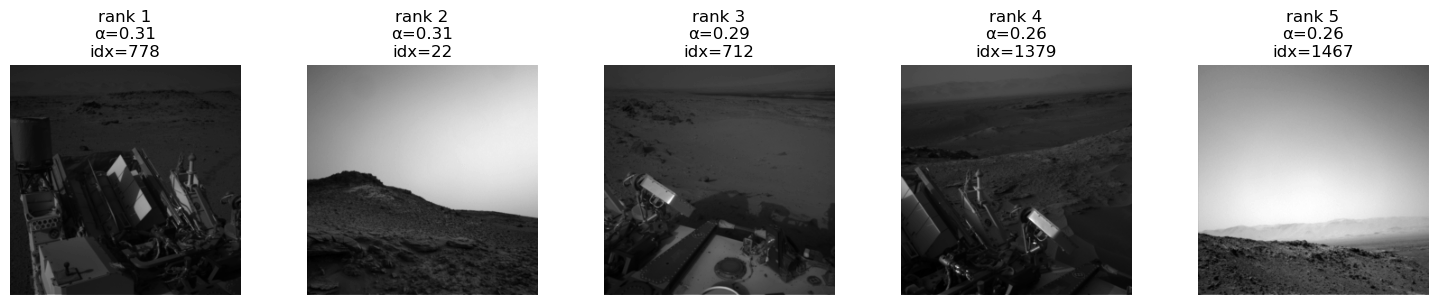


Class 'astronaut' (id=4), NPCA component 1, showing 1 / 1 images.


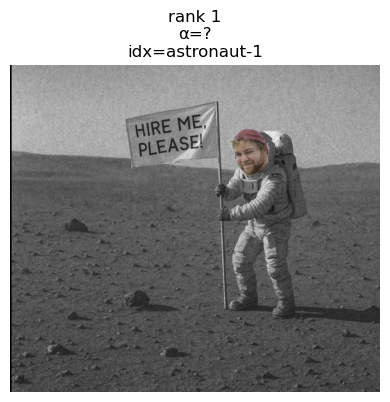

In [ ]:
from martian_terrain_segmentation.explainability import compute_class_neural_pca_features, show_top_neural_pca_images_for_class

class_ids = list(range(len(AI4MARS_CLASS_NAMES)))  # [0,1,2,3]
max_samples_per_class = 200
n_pca_components = 3

neural_pca_results = compute_class_neural_pca_features(
    model=student,
    dataset=train_loader.dataset,   # usually use TRAIN set like in the paper
    device=device,
    class_ids=class_ids,
    max_samples_per_class=max_samples_per_class,
    n_components=n_pca_components,
    min_per_class=10,
)

for c in range(len(AI4MARS_CLASS_NAMES)):
    for comp in range(3):  # top 3 NPCA components
        show_top_neural_pca_images_for_class(
            neural_pca_results,
            dataset=train_loader.dataset,
            class_id=c,
            component_idx=comp,
            top_k=5,
        )
show_top_neural_pca_images_for_class(
        neural_pca_results,
        dataset=train_loader.dataset,
        class_id=-1,
        component_idx=1,
        top_k=5,
    )   


### Neural PCA Conclusion: 

Overall we see a very nice behaviour of the model for each class for the first two components repectively. 
In all the classes we see that for the third compenent we have large parts of the ground being covered by the rover. This means that the rover is part of the representation of the images. This is an issue. Because it is not the first component it is not that bad and this is then probably not a simplicity bias. If we could fix this with a bias model and HSIC regularization term on the target model. There are ways to potentially fix this, but these would require chages to losses and or architectures and remain as future work for now.

In the last component you see another weird behaviour of the model. It is an OOD class. Might be an potential candidate for an internship though.

# 4. Uncertainty Estimation

We consider both:

- **Aleatoric uncertainty** → noise in data  
- **Epistemic uncertainty** → lack of knowledge (model uncertainty)

## 4.1 Aleatoric Uncertainty (Heteroscedastic)

Modify model to output logits $z$ and per-pixel variance $\sigma^2$:

$$
(z, \sigma^2) = f_\theta(x)
$$

Loss:

$$
\mathcal{L} = \frac{1}{\sigma^2}\mathrm{CE}(y,z) + \log\sigma^2
$$

Large $\sigma \Rightarrow$ pixel is inherently noisy.

---

**Disclaimer:**  
Uncertainty disentanglement (splitting into aleatoric and epistemic) is a relatively new and actively debated topic.  
Definitions of the subtypes vary across the literature, so do not treat the definitions here too strictly—they are meant for surface-level illustration in this showcase.

**Reference:**  
https://arxiv.org/abs/1703.04977


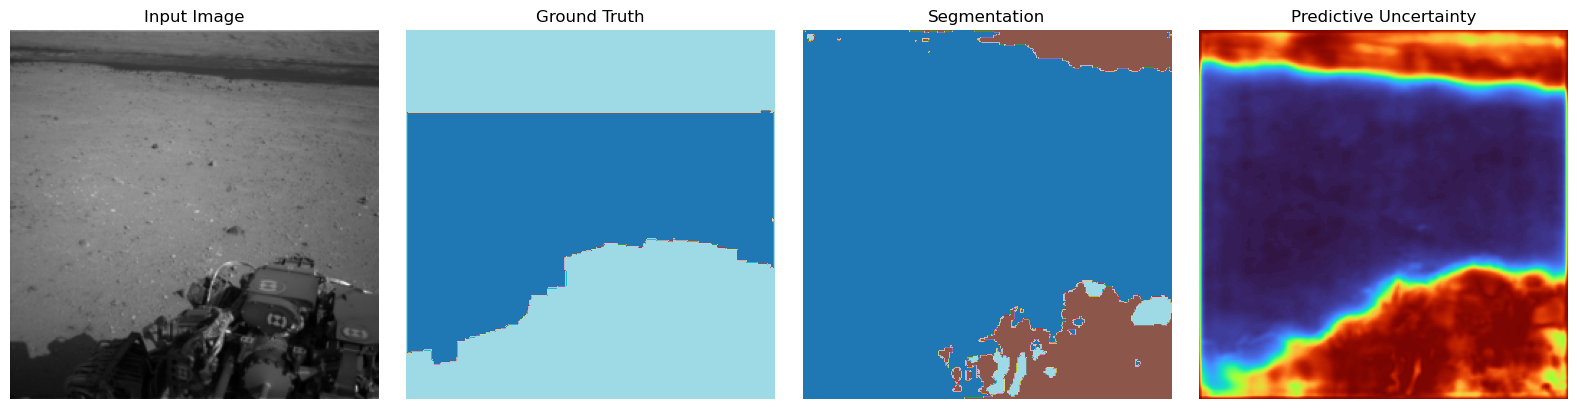

In [ ]:
from martian_terrain_segmentation.uncertainty import predictive_entropy, max_prob_uncertainty

student.eval()
imgs, masks = next(iter(test_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = student(imgs)                     
    preds = logits.argmax(dim=1)            

# choose one example
idx = 0
img_np = imgs[idx, 0].cpu().numpy()
gt_np = masks[idx].cpu().numpy()
pred_np = preds[idx].cpu().numpy()

# uncertainty maps
entropy_map = predictive_entropy(logits)[idx].cpu().numpy()
maxprob_unc = max_prob_uncertainty(logits)[idx].cpu().numpy()

# normalize for display (optional)
def norm01(x):
    x = x.astype("float32")
    x_min, x_max = x.min(), x.max()
    if x_max > x_min:
        return (x - x_min) / (x_max - x_min)
    return x * 0.0

entropy_disp = norm01(entropy_map)
maxprob_unc_disp = norm01(maxprob_unc)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_np, cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(gt_np, cmap="tab20")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(pred_np, cmap="tab20")
axes[2].set_title("Segmentation")
axes[2].axis("off")

axes[3].imshow(entropy_disp, cmap="turbo")  # or "inferno"
axes[3].set_title("Predictive Uncertainty")
axes[3].axis("off")

plt.tight_layout()
plt.show()


## Aleatoric Uncertainty Conclusion:

Here we see that the the uncerainty matches the regions at the predictions roughly. The edges could be a bit more aligned but we do not expect perfect behaviour when having a rather small dataset and a distilled model. One Problem that will arise here for pictures that might be OOD or soft-OOD (weird uncertainty people name for a covariate shift), basically meaning data more or less distict we will suffer from overconfidence. As we have ReLU activations there is the problematic tendency of the model to more confident in one class the more test picture will be away from the training data space. This is obviously wrong behaviour and can be fixed "being a bit Gaussian" (next part).

## 4.2 Epistemic Uncertainty — Laplace Approximation (Future Work)

ReLU networks behave pathologically far from data  
(Hennig & Hauberg: “being a bit Gaussian” helps).

Approximate posterior as Gaussian:

$$
p(\theta \mid D) \approx \mathcal{N}(\hat{\theta}, H^{-1})
$$

where $H$ is the Hessian of the log-posterior.

Provides model uncertainty via parameter variance.

**Reference:**  
https://arxiv.org/abs/2106.15249


# 5. Summary

This project integrates:

- A powerful **Attention U-Net teacher**
- A fast, efficient **student U-Net**
- **Distillation** for performance with small models
- **Multiple explainability tools**
- **Uncertainty estimates** (data & model)

This builds a deployment-ready perception pipeline for autonomous planetary exploration.





# 6. References

### Attention U-Net  
https://arxiv.org/abs/1804.03999

### Knowledge Distillation  
https://arxiv.org/abs/1503.02531

### Grad-CAM  
https://arxiv.org/abs/1610.02391

### Integrated Gradients  
https://arxiv.org/abs/1703.01365

### Aleatoric Uncertainty  
https://arxiv.org/abs/1703.04977

### Laplace Approximation / “Being a Bit Gaussian”  
https://arxiv.org/abs/2106.15249